In [4]:
#!pip install -r requirements.txt

In [1]:
import pandas as pd

train_df = pd.read_csv("train_test_datasets/train_balanced_activities_PROMPT2.csv")
test_df = pd.read_csv("train_test_datasets/test_activities_PROMPT2.csv")

print(train_df["label"].value_counts())
print(test_df["label"].value_counts())
print(train_df["label"].unique())
print(test_df["label"].unique())

print(train_df["label"].dtype, test_df["label"].dtype)

label
1    1902
0    1902
Name: count, dtype: int64
label
0    815
1     85
Name: count, dtype: int64
[1 0]
[1 0]
int64 int64


In [2]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding, EarlyStoppingCallback, get_scheduler
from evaluate import load
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch.optim as optim
import numpy as np

# Load a custom CSV file
data_files = {"train": "train_test_datasets/train_balanced_activities_PROMPT2.csv", "test": "train_test_datasets/test_activities_PROMPT2.csv"}
dataset = load_dataset("csv", data_files=data_files)

# -----------------------------------
# INITIAL INSPECTION
# -----------------------------------

# Inspect the first few samples
print(dataset["train"][0])

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased") #NOTE: Using base model. Increase size for better performance
sample_text = "The purpose of this organization is to provide community services."
tokens = tokenizer(sample_text, padding='max_length', truncation=True, max_length=128)
print(tokens)

def tokenize_function(examples):
    return tokenizer(examples["mission"], padding='max_length', truncation=True, max_length=128)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
print(tokenized_datasets["train"][0])

labels = dataset['train']['label']
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
print(class_weights)

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

{'mission': 'THE ASSOCIATION CONTINUED TO PROMOTE CATHOLICISM, RAISED SUBSTANTIAL FUNDS FOR THE RESTORATION OF THE MONASTERY, AND PERFORMED SERVICES TO RAISE FUNDS FOR IMPROVEMENTS IN THE MONASTERY ESTATE AND CHARITABLE ENDEAVORS.', 'label': 1, 'reason': 'The summary mentions Catholicism and services related to a monastery, indicating a religious focus.'}


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

{'input_ids': [101, 1996, 3800, 1997, 2023, 3029, 2003, 2000, 3073, 2451, 2578, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Map:   0%|          | 0/3804 [00:00<?, ? examples/s]

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

{'mission': 'THE ASSOCIATION CONTINUED TO PROMOTE CATHOLICISM, RAISED SUBSTANTIAL FUNDS FOR THE RESTORATION OF THE MONASTERY, AND PERFORMED SERVICES TO RAISE FUNDS FOR IMPROVEMENTS IN THE MONASTERY ESTATE AND CHARITABLE ENDEAVORS.', 'label': 1, 'reason': 'The summary mentions Catholicism and services related to a monastery, indicating a religious focus.', 'input_ids': [101, 1996, 2523, 2506, 2000, 5326, 16138, 1010, 2992, 6937, 5029, 2005, 1996, 6418, 1997, 1996, 6408, 1010, 1998, 2864, 2578, 2000, 5333, 5029, 2005, 8377, 1999, 1996, 6408, 3776, 1998, 11128, 28809, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [7]:
# -----------------------------------
# SETTING MODEL AND LABELS
# -----------------------------------

# Load model with binary classification head
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
print(model.config)

# Freeze all layers
for param in model.bert.parameters(): # encoder parameters
    param.requires_grad = False

# Unfreeze the 3 encoder layers
for name, param in model.bert.named_parameters():
    if any(f"layer.{i}." in name for i in range(9, 12)):  # unfreeze last 3 instead of just the head
        param.requires_grad = True

# Keep the classification head trainable, always
for param in model.classifier.parameters():
    param.requires_grad = True

print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

optimizer = optim.AdamW(model.parameters())


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "dtype": "float32",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.57.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

Trainable parameters: 21265154


In [11]:
# -----------------------------------
# SETTING PARAMETERS FOR TRAINING
# -----------------------------------

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    save_total_limit=2,
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_dir="./logs",
    logging_steps=500,
    fp16=True,
    #push_to_hub=True
)

In [12]:
# -----------------------------------
# SETTING CUSTOM TRAINER AND CE LOSS
# -----------------------------------
import torch.nn as nn
import torch

class_weights = np.array([1.0, 1.1]) # manually adapting class weights to increase class 1 identification

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get('logits')
        # compute custom loss
        loss_fct = nn.CrossEntropyLoss(weight=torch.from_numpy(class_weights).float().to(logits.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [13]:
# -----------------------------------
# TRAINING AND EVALUATION
# -----------------------------------

metric = load('f1') # accuracy does not work great for imbalanced datasets, f1 is better

def compute_metrics(eval_pred):
    labels = eval_pred.label_ids
    preds = eval_pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

data_collator = DataCollatorWithPadding(tokenizer=tokenizer) # This ensures that each batch is dynamically padded to the longest seq. in the batch

num_training_steps = len(tokenized_datasets["train"]) // training_args.per_device_train_batch_size
num_training_steps *= training_args.num_train_epochs

scheduler = get_scheduler( # this helps start with a small learning rate, increase it gradually and decay afterwards
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps # number of batches * number of epochs
)

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    optimizers=(optimizer, scheduler),
    compute_metrics=compute_metrics
)



trainer.add_callback(EarlyStoppingCallback(early_stopping_patience=4)) # early stop to reach peak performance and avoid overfitting
trainer.train()
# trainer.save_model("./model_on_activities_prompt2")

results = trainer.evaluate()
print(results)

/tmp/ipykernel_1121/1444204356.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.168862,0.964444,0.792208,0.884058,0.717647
2,No log,0.249166,0.948889,0.776699,0.661157,0.941176
3,0.265700,0.334851,0.812222,0.489426,0.329268,0.952941
4,0.265700,0.142111,0.972222,0.864865,0.800000,0.941176
5,0.227400,0.175497,0.973333,0.850000,0.906667,0.800000
6,0.227400,0.227585,0.964444,0.833333,0.747664,0.941176
7,0.215800,0.133150,0.975556,0.879121,0.824742,0.941176
8,0.215800,0.167631,0.968889,0.851064,0.776699,0.941176
9,0.155000,0.108870,0.980000,0.897727,0.868132,0.929412
10,0.155000,0.112657,0.981111,0.901734,0.886364,0.917647


{'eval_loss': 0.10887040197849274, 'eval_accuracy': 0.98, 'eval_f1': 0.8977272727272727, 'eval_precision': 0.8681318681318682, 'eval_recall': 0.9294117647058824, 'eval_runtime': 0.5441, 'eval_samples_per_second': 1654.042, 'eval_steps_per_second': 104.756, 'epoch': 10.0}


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       815
           1       0.87      0.93      0.90        85

    accuracy                           0.98       900
   macro avg       0.93      0.96      0.94       900
weighted avg       0.98      0.98      0.98       900



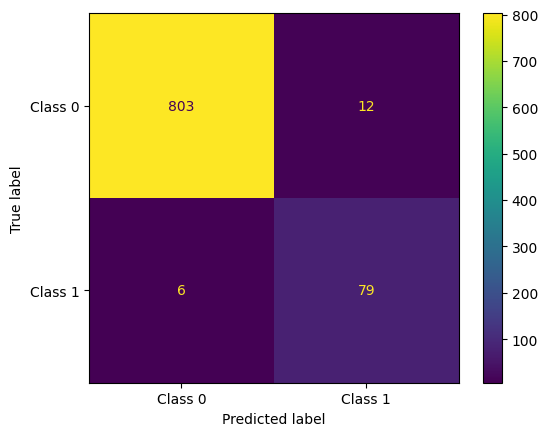

In [14]:
# -----------------------------------
# CLASSIFICATION REPORT AND CONFUSION MATRIX
# -----------------------------------

# Generate predictions
predictions = trainer.predict(tokenized_datasets["test"])
predicted_labels = predictions.predictions.argmax(axis=-1)

# Classification report
print(classification_report(tokenized_datasets["test"]["label"], predicted_labels))

# Confusion matrix
cm = confusion_matrix(tokenized_datasets["test"]["label"], predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot();

In [15]:
for idx, (pred, label) in enumerate(zip(predicted_labels, tokenized_datasets["test"]["label"])):
    if pred != label:
        print(f"Index: {idx}, Predicted: {pred}, Actual: {label}")
        print(tokenized_datasets["test"][idx]["mission"])

Index: 19, Predicted: 0, Actual: 1
THE SCHOOL IS A NON-PROFIT EDUCATIONAL ORGANIZATION THAT PROVIDES A CHSIRTIAN LEARNING ENVIRONMENT WHERE EACH STUDENT MAY ACHIEVE BALANCED GROWTH IN ALL AREAS OF DEVELOPMENT.
Index: 127, Predicted: 1, Actual: 0
St Joseph Zion Ministries is planning to develop public housing in the Fenton, LA community and plan to expand to the Kinder, LA community. Small communities have great schools and the quiet small town atmosphere that can be attractive to many in our population
Index: 164, Predicted: 0, Actual: 1
THE ASSOCIATION MANAGES THE EMPLOYEE APPRECIATION FUND (EAF). FAIRHAVEN ALLOWS NO TIPPING TO ITS EMPLOYEES. INSTEAD THE EAF IS DESIGNED TO PROVIDE GRATUITIES ON A SEMI-ANNUAL BASIS. FUNDS FOR THE EAF ARE DERIVED SOLELY FROM RESIDENT CONTRIBUTIONS. IN 2021 THE RESIDENTS CONTRIBUTED $117,115 AND A TOTAL OF $116,740 WAS DISTRIBUTED TO MORE THAN 200 EMPLOYEES IN JUNE AND DECEMBER. THE EXCESS CONTRIBUTIONS HAVE BEEN HELD FOR DISTRIBUTION IN 2022. THESE ARE 